In [68]:
%load_ext autoreload
%autoreload 2

from toolz import take
import torch as th
from torch.utils.data import DataLoader
from torch import tensor, optim, nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from wxml.model import MLP
from wxml.hamming import make_data_hamming, wt, bittensor, bittensor8, bitvector8, bin_to_dec
from wxml.data import make_splits
from wxml.train import train, count_matches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
batch_size = 1
n_batches = 1000

xs, ys = make_data_hamming(batch_size * n_batches)

[print(xy) for xy in take(5, zip(xs, ys))]

ds_train, ds_val, ds_test = make_splits(xs, ys)
train_loader, val_loader, test_loader = [DataLoader(d, batch_size=batch_size, shuffle=False) for d in [ds_train, ds_val, ds_test]]

(tensor([0., 0., 0., 1., 1., 0., 0., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 0.], requires_grad=True))
(tensor([0., 0., 1., 1., 0., 1., 1., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 0., 1.], requires_grad=True))
(tensor([0., 0., 0., 1., 1., 0., 1., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 0., 0.], requires_grad=True))
(tensor([0., 0., 1., 0., 0., 1., 1., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 1.], requires_grad=True))
(tensor([0., 0., 0., 0., 0., 1., 1., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 1.], requires_grad=True))


In [30]:
num_layers = 2
input_dim = 8
hidden_dim = 32
output_dim = 8

lr = 1e-3

epochs = 50

model = nn.Sequential(MLP(num_layers, input_dim, hidden_dim, output_dim), nn.Sigmoid())
# model = th.compile(model)
opt = optim.AdamW(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

results = train(model, loss_fn, opt, train_loader, val_loader, epochs=epochs, device='mps', dtype=th.float32, print_every=n_batches // 10)


  0%|          | 0/50 [00:00<?, ?it/s]

5.0 tensor([[0., 0., 0., 0., 0., 1., 0., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 0., 1., 1.]], device='mps:0')
6.0 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 0., 1., 1.]], device='mps:0')
8.0 tensor([[0., 0., 0., 0., 0., 0., 1., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 0., 1., 0.]], device='mps:0')
8.0 tensor([[0., 0., 0., 0., 0., 1., 0., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 1., 0., 0.]], device='mps:0')
6.0 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 0., 1., 1.]], device='mps:0')
8.0 tensor([[0., 0., 0., 0., 0., 1., 0., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 1., 0., 0.]], device='mps:0')
7.0 tensor([[0., 0., 0., 0., 0., 1., 0., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 1., 0., 1.]], device='mps:0')
8.0 tensor([[0., 0., 0., 0., 0., 0., 1., 0.]], device='mps:0') tensor([[0., 0., 0., 0., 0., 0., 1., 0.]], device='mps:0')
6.0 tensor([[0., 0., 0.,

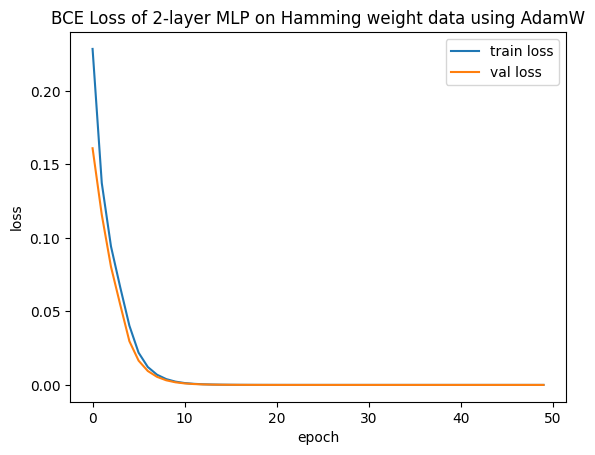

In [5]:
plt.plot(results['train_losses'], label='train loss')
plt.plot(results['val_losses'], label='val loss')
plt.title("BCE Loss of 2-layer MLP on Hamming weight data using AdamW")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

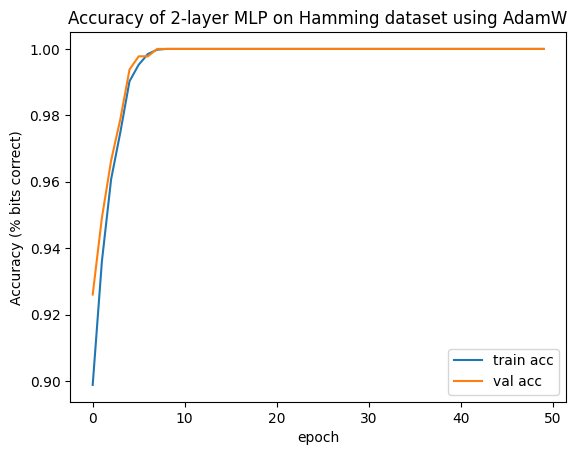

In [6]:
plt.plot(results['train_accuracies'], label='train acc')
plt.plot(results['val_accuracies'], label='val acc')
plt.title("Accuracy of 2-layer MLP on Hamming dataset using AdamW")
plt.ylabel("Accuracy (% bits correct)")
plt.xlabel("epoch")
plt.legend()
plt.show()

tensor([0., 0., 0., 0., 1., 0., 0., 0.])

In [34]:
count_matches(bittensor(wt(x), n=8).to('mps'), (model(x).round()))

8.0

In [65]:
rounded([0.1341513, 0])

[0.1342, 0]

In [71]:
bin_to_dec([0, 0, 0, 0, 0, 0, 1, 1])

3

In [ ]:
# TODO

def rounded(xs):
    return [round(x, 4) for x in xs]

def round01(x):
    return x.round()

th.set_printoptions(sci_mode=False, precision=4)

# x, bin(x), wt(bin(x)), bin(wt(bin(x))), f(x), round(f(x)), wt(round(f(x))), bin(wt(round(f(x))), n
print("x | bin(x) | wt(bin(x)) | bin(wt(bin(x))) | f(bin(x)) | round(f(x)) | base10(round(f(x))) | n")
for x in range(256):
    # bin_x = bittensor(x, 8).int().tolist()
    bin_x = bittensor8(x)
    wt_bin_x = wt(bin_x)
    bin_wt_bin_x = bittensor8(wt_bin_x)
    f_x = model(bin_x.to('mps'))
    round_f_x = round01(f_x)
    base10_round_f_x = bin_to_dec(round_f_x.int().tolist())
    n = 8 - count_matches(round_f_x.to('mps'), bin_wt_bin_x.to('mps'))
    print(f"{x} | {bin_x.int().tolist()} | {wt_bin_x.int().tolist()} | {bin_wt_bin_x.int().tolist()} | {rounded(f_x.tolist())} | {round_f_x.int().tolist()} | {base10_round_f_x} | {n}")

x | bin(x) | wt(bin(x)) | bin(wt(bin(x))) | f(bin(x)) | round(f(x)) | base10(round(f(x))) | n
0 | [0, 0, 0, 0, 0, 0, 0, 0] | 0 | [0, 0, 0, 0, 0, 0, 0, 0] | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003] | [0, 0, 0, 0, 0, 0, 0, 0] | 0 | 8.0
1 | [0, 0, 0, 0, 0, 0, 0, 1] | 1 | [0, 0, 0, 0, 0, 0, 0, 1] | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996] | [0, 0, 0, 0, 0, 0, 0, 1] | 1 | 8.0
2 | [0, 0, 0, 0, 0, 0, 1, 0] | 1 | [0, 0, 0, 0, 0, 0, 0, 1] | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9986] | [0, 0, 0, 0, 0, 0, 0, 1] | 1 | 8.0
3 | [0, 0, 0, 0, 0, 0, 1, 1] | 2 | [0, 0, 0, 0, 0, 0, 1, 0] | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0002] | [0, 0, 0, 0, 0, 0, 1, 0] | 2 | 8.0
4 | [0, 0, 0, 0, 0, 1, 0, 0] | 1 | [0, 0, 0, 0, 0, 0, 0, 1] | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999] | [0, 0, 0, 0, 0, 0, 0, 1] | 1 | 8.0
5 | [0, 0, 0, 0, 0, 1, 0, 1] | 2 | [0, 0, 0, 0, 0, 0, 1, 0] | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0001] | [0, 0, 0, 0, 0, 0, 1, 0] | 2 | 8.0
6 | [0, 0, 0, 0, 0, 1, 1, 0] | 2 | [0, 0, 0, 0, 

In [ ]:
# TODO: get accuracy for hamming weights not in train set
# TODO: make validation set contains hamming weights not in train set
# TODO: Hypothesis: the NN can only learn bitvectors up to a certain length

x = tensor([[0, 0, 0, 0, 0, 0, 1, 1]], device='mps').float()

th.set_printoptions(sci_mode=False)
with th.no_grad():
    print(model(x))

tensor([[    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     1.0000,
             0.0000,     0.0002]], device='mps:0')
